# INTRODUCTION

## Overview

Natural Language Processing is a complex field which is hypothesised to be part of AI-complete set of problems, implying that the difficulty of these computational problems is equivalent to that of solving the central artificial intelligence problem of making computers as intelligent as people. With over 90% of data ever generated being produced in the last 2 years and with a great proportion being human generated unstructured text there is an ever increasing need to advance the field of Natural Language Processing.

Recent UK Government proposal to have measures to regulate social media companies over harmful content, including "substantial" fines and the ability to block services that do not stick to the rules is an example of the regulamentary need to better manage the content that is being generated by users.

Other initiatives like ​Riot Games​' work aimed to predict and reform toxic player behaviour during games is another example of this effort to understand the content being generated by users and moderate toxic content.
However, as highlighted by the Kaggle competition ​Jigsaw unintended bias in toxicity classification​, existing models suffer from unintended bias where models might predict high likelihood of toxicity for content containing certain words (e.g. "gay") even when those comments were not actually toxic (such as "I am a gay woman"), leaving machine only classification models still sub-standard.

The outcome of our analysis is the type of algorithm that companies will use to define what is free speech and what shouldn't be tolerated in a discussion. This challenge actually starts with how the training dataset was produced: Multiple people (annotators) read thousands of comments and defined if those comments were offensive or not. Where is the trick? They disagreed in many of them. Having tools that are able to flag up toxic content without suffering from unintended bias is of paramount importance to preserve Internet's fairness and freedom of speech

## Dataset

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.

In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment.

For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).


In [1]:
import warnings
warnings.filterwarnings('ignore')



In [2]:
from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import missingno as msno


import numpy as np
import pandas as pd
from scipy import stats
import spacy
from sklearn.decomposition import PCA

from wordcloud import WordCloud ,STOPWORDS

import watermark

from tqdm import tqdm_notebook

from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
from sklearn.model_selection import train_test_split,cross_val_score
import operator
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
#lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])#
#nltk.download('wordnet')

%load_ext watermark

import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler,robust_scale,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn import metrics

from nltk.tokenize import TweetTokenizer,sent_tokenize, word_tokenize 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, add
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks,Sequential
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam



PROJ_ROOT = os.path.join(os.pardir)

#print(os.path.abspath(PROJ_ROOT))

C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\smart_open\ssh.py:34: UserWarning:

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress

C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\gensim\utils.py:1197: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial

Using TensorFlow backend.


In [3]:
train= pd.read_csv('../Data/train.csv')
#test= pd.read_csv('../Data/test.csv')


In [4]:
train['target'] = np.where(train['target'] >= 0.5, True, False)    

In [5]:
train_temp, test_temp = train_test_split(train, test_size=0.1, stratify=train['target'])

In [6]:
#identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
#for col in identity_columns + ['target']:
print(train_temp.shape)
print(test_temp.shape)

(1624386, 45)
(180488, 45)


In [7]:
y_test = test_temp['target']

In [8]:
#Split train in train and validate
train_df, valid_df = train_test_split(train_temp, test_size=0.33, stratify=train_temp['target'])
test_df=test_temp
#train_df=train_df[:250000]
train_df=train_df
train_df.loc[:,'set_']="train"
valid_df.loc[:,'set_']="valid"
test_df.loc[:,'set_']="test"

train_df, valid_df = train_test_split(train_df, test_size=0.33, stratify=train['target'])
#test_df=null
#train_df=train_df[:500000]
#train_df=train_df

train_df.loc[:,'set_']="train"
valid_df.loc[:,'set_']="valid"
#test_df.loc[:,'set_']="test"

In [9]:
#Set_indices=train_df.loc[:,'set_'][:500000]
Set_indices=train_df.loc[:,'set_']
Set_indices=Set_indices.append(valid_df.loc[:,'set_'])
Set_indices=Set_indices.append(test_df.loc[:,'set_'])


#y_train = train_df['target'][:500000]
y_train = train_df['target']
y_valid = valid_df['target']

#Set_indices_labels=train_df.loc[:,'set_'][:500000]
Set_indices_labels=train_df.loc[:,'set_']
Set_indices_labels=Set_indices_labels.append(valid_df.loc[:,'set_'])



In [10]:
texts=train_df['comment_text']
texts=texts.append(valid_df['comment_text'])
texts=texts.append(test_df['comment_text'])

print(texts.shape)

labels=train_df['target']
labels=labels.append(valid_df['target'])

print(labels.shape)

(1804874,)
(1624386,)


In [11]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    from tensorflow import set_random_seed
    set_random_seed(2)

seed_everything()

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150
max_words = 90000
embedding_size=300
lr = 1e-3
lr_d = 0


tokenizer = Tokenizer(num_words=max_words)


In [13]:
tokenizer.fit_on_texts(texts)


In [14]:
sequences = tokenizer.texts_to_sequences(texts)

In [15]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 397708 unique tokens.
Shape of data tensor: (1804874, 150)
Shape of label tensor: (1624386,)


In [16]:
x_train = data[Set_indices == "train"]
x_val = data[Set_indices == "valid"]
x_test = data[Set_indices == "test"]


y_train = labels[Set_indices_labels == "train"]
y_val = labels[Set_indices_labels == "valid"]

print('Shape of train tensor:', x_train.shape)
print('Shape of validate tensor:', x_val.shape)
print('Shape of test tensor:', x_val.shape)

Shape of train tensor: (1088338, 150)
Shape of validate tensor: (536048, 150)
Shape of test tensor: (536048, 150)


In [17]:
glove_dir = '../glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))


In [19]:
embedding_matrix.shape

(90000, 100)

In [20]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
         #   print(embedding_matrix)

In [21]:
embedding_matrix.shape

(90000, 100)

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          9000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 9,480,065
Trainable params: 9,480,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
#model.layers[2].get_weights()

In [24]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=1024,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1088338 samples, validate on 536048 samples
Epoch 1/20


 437248/1088338 [===========>..................] - ETA: 21:49 - loss: 0.8252 - acc: 0.24 - ETA: 7:38 - loss: 0.5404 - acc: 0.6911 - ETA: 4:47 - loss: 0.5300 - acc: 0.779 - ETA: 3:34 - loss: 0.4829 - acc: 0.823 - ETA: 2:53 - loss: 0.4609 - acc: 0.843 - ETA: 2:27 - loss: 0.4359 - acc: 0.856 - ETA: 2:09 - loss: 0.4165 - acc: 0.866 - ETA: 1:56 - loss: 0.4048 - acc: 0.873 - ETA: 1:45 - loss: 0.3919 - acc: 0.878 - ETA: 1:37 - loss: 0.3792 - acc: 0.883 - ETA: 1:31 - loss: 0.3720 - acc: 0.886 - ETA: 1:25 - loss: 0.3672 - acc: 0.888 - ETA: 1:21 - loss: 0.3617 - acc: 0.890 - ETA: 1:17 - loss: 0.3557 - acc: 0.892 - ETA: 1:14 - loss: 0.3495 - acc: 0.894 - ETA: 1:11 - loss: 0.3449 - acc: 0.896 - ETA: 1:08 - loss: 0.3403 - acc: 0.897 - ETA: 1:06 - loss: 0.3359 - acc: 0.899 - ETA: 1:04 - loss: 0.3332 - acc: 0.900 - ETA: 1:02 - loss: 0.3301 - acc: 0.901 - ETA: 1:00 - loss: 0.3271 - acc: 0.901 - ETA: 59s - loss: 0.3242 - acc: 0.902 - ETA: 57s - loss: 0.3203 - acc: 0.90 - ETA: 56s - loss: 0.3180 - acc: 

 877568/1088338 [=======================>......] - ETA: 20s - loss: 0.2210 - acc: 0.92 - ETA: 20s - loss: 0.2208 - acc: 0.92 - ETA: 20s - loss: 0.2206 - acc: 0.92 - ETA: 20s - loss: 0.2205 - acc: 0.92 - ETA: 20s - loss: 0.2203 - acc: 0.92 - ETA: 20s - loss: 0.2201 - acc: 0.92 - ETA: 20s - loss: 0.2200 - acc: 0.92 - ETA: 20s - loss: 0.2198 - acc: 0.92 - ETA: 20s - loss: 0.2196 - acc: 0.92 - ETA: 20s - loss: 0.2195 - acc: 0.92 - ETA: 19s - loss: 0.2194 - acc: 0.92 - ETA: 19s - loss: 0.2192 - acc: 0.92 - ETA: 19s - loss: 0.2189 - acc: 0.92 - ETA: 19s - loss: 0.2188 - acc: 0.92 - ETA: 19s - loss: 0.2186 - acc: 0.92 - ETA: 19s - loss: 0.2184 - acc: 0.92 - ETA: 19s - loss: 0.2182 - acc: 0.92 - ETA: 19s - loss: 0.2180 - acc: 0.92 - ETA: 19s - loss: 0.2177 - acc: 0.92 - ETA: 19s - loss: 0.2176 - acc: 0.92 - ETA: 19s - loss: 0.2174 - acc: 0.92 - ETA: 19s - loss: 0.2172 - acc: 0.92 - ETA: 19s - loss: 0.2170 - acc: 0.92 - ETA: 19s - loss: 0.2168 - acc: 0.92 - ETA: 19s - loss: 0.2167 - acc: 0.92 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.1937 - acc: 0.930 - ETA: 6s - loss: 0.1936 - acc: 0.930 - ETA: 6s - loss: 0.1936 - acc: 0.930 - ETA: 6s - loss: 0.1935 - acc: 0.930 - ETA: 6s - loss: 0.1934 - acc: 0.930 - ETA: 6s - loss: 0.1933 - acc: 0.930 - ETA: 6s - loss: 0.1932 - acc: 0.930 - ETA: 5s - loss: 0.1932 - acc: 0.930 - ETA: 5s - loss: 0.1930 - acc: 0.930 - ETA: 5s - loss: 0.1930 - acc: 0.930 - ETA: 5s - loss: 0.1929 - acc: 0.930 - ETA: 5s - loss: 0.1928 - acc: 0.930 - ETA: 5s - loss: 0.1927 - acc: 0.930 - ETA: 5s - loss: 0.1926 - acc: 0.930 - ETA: 5s - loss: 0.1925 - acc: 0.930 - ETA: 5s - loss: 0.1924 - acc: 0.930 - ETA: 5s - loss: 0.1923 - acc: 0.930 - ETA: 5s - loss: 0.1922 - acc: 0.930 - ETA: 5s - loss: 0.1921 - acc: 0.930 - ETA: 5s - loss: 0.1920 - acc: 0.931 - ETA: 5s - loss: 0.1919 - acc: 0.931 - ETA: 5s - loss: 0.1918 - acc: 0.931 - ETA: 5s - loss: 0.1917 - acc: 0.931 - ETA: 4s - loss: 0.1916 - acc: 0.931 - ETA: 4s - loss: 0.1915 - acc: 0.931 -

 439296/1088338 [===========>..................] - ETA: 1:00 - loss: 0.1506 - acc: 0.940 - ETA: 41s - loss: 0.1464 - acc: 0.941 - ETA: 37s - loss: 0.1443 - acc: 0.94 - ETA: 35s - loss: 0.1389 - acc: 0.94 - ETA: 35s - loss: 0.1422 - acc: 0.94 - ETA: 34s - loss: 0.1409 - acc: 0.94 - ETA: 33s - loss: 0.1410 - acc: 0.94 - ETA: 33s - loss: 0.1385 - acc: 0.94 - ETA: 33s - loss: 0.1377 - acc: 0.94 - ETA: 33s - loss: 0.1369 - acc: 0.94 - ETA: 32s - loss: 0.1374 - acc: 0.94 - ETA: 32s - loss: 0.1365 - acc: 0.94 - ETA: 32s - loss: 0.1360 - acc: 0.94 - ETA: 32s - loss: 0.1341 - acc: 0.94 - ETA: 32s - loss: 0.1339 - acc: 0.94 - ETA: 32s - loss: 0.1350 - acc: 0.94 - ETA: 31s - loss: 0.1350 - acc: 0.94 - ETA: 31s - loss: 0.1359 - acc: 0.94 - ETA: 31s - loss: 0.1354 - acc: 0.94 - ETA: 31s - loss: 0.1357 - acc: 0.94 - ETA: 31s - loss: 0.1355 - acc: 0.94 - ETA: 31s - loss: 0.1350 - acc: 0.94 - ETA: 31s - loss: 0.1354 - acc: 0.94 - ETA: 31s - loss: 0.1356 - acc: 0.94 - ETA: 31s - loss: 0.1354 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.1327 - acc: 0.94 - ETA: 19s - loss: 0.1327 - acc: 0.94 - ETA: 19s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1326 - acc: 0.94 - ETA: 18s - loss: 0.1326 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1326 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1328 - acc: 0.94 - ETA: 18s - loss: 0.1328 - acc: 0.94 - ETA: 18s - loss: 0.1328 - acc: 0.94 - ETA: 18s - loss: 0.1328 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1327 - acc: 0.94 - ETA: 18s - loss: 0.1328 - acc: 0.94 - ETA: 18s - loss: 0.1328 - acc: 0.94 - ETA: 17s - loss: 0.1328 - acc: 0.94 - ETA: 17s - loss: 0.1327 - acc: 0.94 - ETA: 17s - loss: 0.1327 - acc: 0.94 - ETA: 17s - loss: 0.1327 - acc: 0.94 - ETA: 17s - loss: 0.1327 - acc: 0.94 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.1324 - acc: 0.949 - ETA: 6s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1325 - acc: 0.949 - ETA: 5s - loss: 0.1325 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1324 - acc: 0.949 - ETA: 5s - loss: 0.1323 - acc: 0.949 - ETA: 5s - loss: 0.1323 - acc: 0.949 - ETA: 5s - loss: 0.1323 - acc: 0.949 - ETA: 5s - loss: 0.1323 - acc: 0.949 - ETA: 5s - loss: 0.1323 - acc: 0.949 - ETA: 5s - loss: 0.1323 - acc: 0.949 - ETA: 4s - loss: 0.1323 - acc: 0.949 - ETA: 4s - loss: 0.1323 - acc: 0.949 - ETA: 4s - loss: 0.1323 - acc: 0.949 - ETA: 4s - loss: 0.1323 - acc: 0.949 - ETA: 4s - loss: 0.1323 - acc: 0.949 - ETA: 4s - loss: 0.1323 - acc: 0.949 -

 439296/1088338 [===========>..................] - ETA: 1:00 - loss: 0.1143 - acc: 0.952 - ETA: 40s - loss: 0.1184 - acc: 0.951 - ETA: 37s - loss: 0.1140 - acc: 0.95 - ETA: 35s - loss: 0.1148 - acc: 0.95 - ETA: 34s - loss: 0.1144 - acc: 0.95 - ETA: 34s - loss: 0.1170 - acc: 0.95 - ETA: 33s - loss: 0.1158 - acc: 0.95 - ETA: 33s - loss: 0.1149 - acc: 0.95 - ETA: 33s - loss: 0.1134 - acc: 0.95 - ETA: 32s - loss: 0.1131 - acc: 0.95 - ETA: 32s - loss: 0.1133 - acc: 0.95 - ETA: 32s - loss: 0.1109 - acc: 0.95 - ETA: 32s - loss: 0.1100 - acc: 0.95 - ETA: 32s - loss: 0.1089 - acc: 0.95 - ETA: 32s - loss: 0.1091 - acc: 0.95 - ETA: 32s - loss: 0.1097 - acc: 0.95 - ETA: 32s - loss: 0.1102 - acc: 0.95 - ETA: 31s - loss: 0.1100 - acc: 0.95 - ETA: 31s - loss: 0.1100 - acc: 0.95 - ETA: 31s - loss: 0.1102 - acc: 0.95 - ETA: 31s - loss: 0.1103 - acc: 0.95 - ETA: 31s - loss: 0.1101 - acc: 0.95 - ETA: 31s - loss: 0.1101 - acc: 0.95 - ETA: 31s - loss: 0.1105 - acc: 0.95 - ETA: 31s - loss: 0.1102 - acc: 0.9

 878592/1088338 [=======================>......] - ETA: 19s - loss: 0.1110 - acc: 0.95 - ETA: 19s - loss: 0.1110 - acc: 0.95 - ETA: 19s - loss: 0.1110 - acc: 0.95 - ETA: 19s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1110 - acc: 0.95 - ETA: 18s - loss: 0.1110 - acc: 0.95 - ETA: 18s - loss: 0.1110 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1110 - acc: 0.95 - ETA: 18s - loss: 0.1110 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 18s - loss: 0.1111 - acc: 0.95 - ETA: 17s - loss: 0.1111 - acc: 0.95 - ETA: 17s - loss: 0.1111 - acc: 0.95 - ETA: 17s - loss: 0.1111 - acc: 0.95 - ETA: 17s - loss: 0.1111 - acc: 0.95 - ETA: 17s - loss: 0.1111 - acc: 0.95 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.1130 - acc: 0.954 - ETA: 6s - loss: 0.1130 - acc: 0.954 - ETA: 6s - loss: 0.1130 - acc: 0.954 - ETA: 6s - loss: 0.1130 - acc: 0.954 - ETA: 6s - loss: 0.1130 - acc: 0.954 - ETA: 6s - loss: 0.1130 - acc: 0.954 - ETA: 5s - loss: 0.1130 - acc: 0.954 - ETA: 5s - loss: 0.1130 - acc: 0.954 - ETA: 5s - loss: 0.1130 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1130 - acc: 0.954 - ETA: 5s - loss: 0.1130 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 5s - loss: 0.1131 - acc: 0.954 - ETA: 4s - loss: 0.1131 - acc: 0.954 - ETA: 4s - loss: 0.1132 - acc: 0.954 - ETA: 4s - loss: 0.1132 - acc: 0.954 -

 438272/1088338 [===========>..................] - ETA: 1:04 - loss: 0.0991 - acc: 0.955 - ETA: 42s - loss: 0.1023 - acc: 0.958 - ETA: 38s - loss: 0.1063 - acc: 0.95 - ETA: 36s - loss: 0.1012 - acc: 0.95 - ETA: 35s - loss: 0.1006 - acc: 0.95 - ETA: 34s - loss: 0.0995 - acc: 0.95 - ETA: 34s - loss: 0.0986 - acc: 0.95 - ETA: 33s - loss: 0.0962 - acc: 0.96 - ETA: 33s - loss: 0.0953 - acc: 0.96 - ETA: 33s - loss: 0.0940 - acc: 0.96 - ETA: 33s - loss: 0.0944 - acc: 0.96 - ETA: 32s - loss: 0.0939 - acc: 0.96 - ETA: 32s - loss: 0.0936 - acc: 0.96 - ETA: 32s - loss: 0.0935 - acc: 0.96 - ETA: 32s - loss: 0.0940 - acc: 0.96 - ETA: 32s - loss: 0.0939 - acc: 0.96 - ETA: 32s - loss: 0.0942 - acc: 0.96 - ETA: 31s - loss: 0.0943 - acc: 0.96 - ETA: 31s - loss: 0.0934 - acc: 0.96 - ETA: 31s - loss: 0.0931 - acc: 0.96 - ETA: 31s - loss: 0.0931 - acc: 0.96 - ETA: 31s - loss: 0.0924 - acc: 0.96 - ETA: 31s - loss: 0.0922 - acc: 0.96 - ETA: 31s - loss: 0.0925 - acc: 0.96 - ETA: 31s - loss: 0.0922 - acc: 0.9

 878592/1088338 [=======================>......] - ETA: 20s - loss: 0.0961 - acc: 0.96 - ETA: 20s - loss: 0.0960 - acc: 0.96 - ETA: 20s - loss: 0.0961 - acc: 0.96 - ETA: 20s - loss: 0.0960 - acc: 0.96 - ETA: 20s - loss: 0.0961 - acc: 0.96 - ETA: 20s - loss: 0.0961 - acc: 0.96 - ETA: 20s - loss: 0.0961 - acc: 0.96 - ETA: 20s - loss: 0.0961 - acc: 0.96 - ETA: 19s - loss: 0.0962 - acc: 0.96 - ETA: 19s - loss: 0.0962 - acc: 0.96 - ETA: 19s - loss: 0.0962 - acc: 0.96 - ETA: 19s - loss: 0.0962 - acc: 0.96 - ETA: 19s - loss: 0.0963 - acc: 0.96 - ETA: 19s - loss: 0.0963 - acc: 0.96 - ETA: 19s - loss: 0.0963 - acc: 0.96 - ETA: 19s - loss: 0.0963 - acc: 0.96 - ETA: 19s - loss: 0.0963 - acc: 0.96 - ETA: 19s - loss: 0.0964 - acc: 0.96 - ETA: 19s - loss: 0.0964 - acc: 0.96 - ETA: 19s - loss: 0.0964 - acc: 0.96 - ETA: 19s - loss: 0.0964 - acc: 0.96 - ETA: 19s - loss: 0.0964 - acc: 0.96 - ETA: 19s - loss: 0.0964 - acc: 0.96 - ETA: 18s - loss: 0.0964 - acc: 0.96 - ETA: 18s - loss: 0.0963 - acc: 0.96 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 6s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0972 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 5s - loss: 0.0973 - acc: 0.960 - ETA: 4s - loss: 0.0973 - acc: 0.960 -

 439296/1088338 [===========>..................] - ETA: 58s - loss: 0.0916 - acc: 0.97 - ETA: 40s - loss: 0.0900 - acc: 0.97 - ETA: 37s - loss: 0.0868 - acc: 0.96 - ETA: 35s - loss: 0.0854 - acc: 0.96 - ETA: 34s - loss: 0.0814 - acc: 0.96 - ETA: 34s - loss: 0.0795 - acc: 0.96 - ETA: 33s - loss: 0.0789 - acc: 0.96 - ETA: 33s - loss: 0.0769 - acc: 0.97 - ETA: 33s - loss: 0.0763 - acc: 0.97 - ETA: 33s - loss: 0.0768 - acc: 0.97 - ETA: 33s - loss: 0.0765 - acc: 0.97 - ETA: 32s - loss: 0.0767 - acc: 0.97 - ETA: 32s - loss: 0.0758 - acc: 0.97 - ETA: 32s - loss: 0.0754 - acc: 0.97 - ETA: 32s - loss: 0.0749 - acc: 0.97 - ETA: 32s - loss: 0.0743 - acc: 0.97 - ETA: 32s - loss: 0.0747 - acc: 0.97 - ETA: 31s - loss: 0.0745 - acc: 0.97 - ETA: 31s - loss: 0.0746 - acc: 0.97 - ETA: 31s - loss: 0.0743 - acc: 0.97 - ETA: 31s - loss: 0.0742 - acc: 0.97 - ETA: 31s - loss: 0.0739 - acc: 0.97 - ETA: 31s - loss: 0.0737 - acc: 0.97 - ETA: 31s - loss: 0.0734 - acc: 0.97 - ETA: 31s - loss: 0.0737 - acc: 0.97 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 19s - loss: 0.0772 - acc: 0.96 - ETA: 19s - loss: 0.0772 - acc: 0.96 - ETA: 19s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0772 - acc: 0.96 - ETA: 18s - loss: 0.0772 - acc: 0.96 - ETA: 18s - loss: 0.0772 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 18s - loss: 0.0772 - acc: 0.96 - ETA: 18s - loss: 0.0772 - acc: 0.96 - ETA: 18s - loss: 0.0771 - acc: 0.96 - ETA: 17s - loss: 0.0771 - acc: 0.96 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0794 - acc: 0.968 - ETA: 6s - loss: 0.0794 - acc: 0.968 - ETA: 6s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0794 - acc: 0.968 - ETA: 5s - loss: 0.0794 - acc: 0.968 - ETA: 5s - loss: 0.0794 - acc: 0.968 - ETA: 5s - loss: 0.0794 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0794 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 5s - loss: 0.0795 - acc: 0.968 - ETA: 4s - loss: 0.0796 - acc: 0.968 - ETA: 4s - loss: 0.0796 - acc: 0.968 - ETA: 4s - loss: 0.0796 - acc: 0.968 - ETA: 4s - loss: 0.0796 - acc: 0.968 - ETA: 4s - loss: 0.0795 - acc: 0.968 - ETA: 4s - loss: 0.0796 - acc: 0.968 -

 439296/1088338 [===========>..................] - ETA: 1:14 - loss: 0.0603 - acc: 0.981 - ETA: 46s - loss: 0.0616 - acc: 0.979 - ETA: 40s - loss: 0.0624 - acc: 0.97 - ETA: 38s - loss: 0.0611 - acc: 0.97 - ETA: 37s - loss: 0.0604 - acc: 0.97 - ETA: 36s - loss: 0.0601 - acc: 0.97 - ETA: 35s - loss: 0.0603 - acc: 0.97 - ETA: 35s - loss: 0.0611 - acc: 0.97 - ETA: 34s - loss: 0.0610 - acc: 0.97 - ETA: 34s - loss: 0.0608 - acc: 0.97 - ETA: 34s - loss: 0.0612 - acc: 0.97 - ETA: 33s - loss: 0.0598 - acc: 0.97 - ETA: 33s - loss: 0.0605 - acc: 0.97 - ETA: 33s - loss: 0.0599 - acc: 0.97 - ETA: 33s - loss: 0.0600 - acc: 0.97 - ETA: 33s - loss: 0.0600 - acc: 0.97 - ETA: 32s - loss: 0.0600 - acc: 0.97 - ETA: 32s - loss: 0.0596 - acc: 0.97 - ETA: 32s - loss: 0.0604 - acc: 0.97 - ETA: 32s - loss: 0.0602 - acc: 0.97 - ETA: 32s - loss: 0.0596 - acc: 0.97 - ETA: 32s - loss: 0.0593 - acc: 0.97 - ETA: 32s - loss: 0.0587 - acc: 0.97 - ETA: 31s - loss: 0.0590 - acc: 0.97 - ETA: 31s - loss: 0.0588 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0594 - acc: 0.97 - ETA: 19s - loss: 0.0595 - acc: 0.97 - ETA: 19s - loss: 0.0595 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 19s - loss: 0.0596 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0598 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 - ETA: 18s - loss: 0.0597 - acc: 0.97 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 6s - loss: 0.0613 - acc: 0.976 - ETA: 6s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0614 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 5s - loss: 0.0615 - acc: 0.976 - ETA: 4s - loss: 0.0615 - acc: 0.976 -

 439296/1088338 [===========>..................] - ETA: 1:02 - loss: 0.0344 - acc: 0.981 - ETA: 42s - loss: 0.0424 - acc: 0.981 - ETA: 38s - loss: 0.0404 - acc: 0.98 - ETA: 36s - loss: 0.0429 - acc: 0.98 - ETA: 35s - loss: 0.0416 - acc: 0.98 - ETA: 34s - loss: 0.0419 - acc: 0.98 - ETA: 34s - loss: 0.0418 - acc: 0.98 - ETA: 34s - loss: 0.0415 - acc: 0.98 - ETA: 33s - loss: 0.0418 - acc: 0.98 - ETA: 33s - loss: 0.0413 - acc: 0.98 - ETA: 33s - loss: 0.0409 - acc: 0.98 - ETA: 32s - loss: 0.0408 - acc: 0.98 - ETA: 32s - loss: 0.0418 - acc: 0.98 - ETA: 32s - loss: 0.0415 - acc: 0.98 - ETA: 32s - loss: 0.0414 - acc: 0.98 - ETA: 32s - loss: 0.0415 - acc: 0.98 - ETA: 32s - loss: 0.0416 - acc: 0.98 - ETA: 32s - loss: 0.0416 - acc: 0.98 - ETA: 31s - loss: 0.0416 - acc: 0.98 - ETA: 31s - loss: 0.0416 - acc: 0.98 - ETA: 31s - loss: 0.0417 - acc: 0.98 - ETA: 31s - loss: 0.0421 - acc: 0.98 - ETA: 31s - loss: 0.0419 - acc: 0.98 - ETA: 31s - loss: 0.0418 - acc: 0.98 - ETA: 31s - loss: 0.0415 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0435 - acc: 0.98 - ETA: 19s - loss: 0.0435 - acc: 0.98 - ETA: 19s - loss: 0.0436 - acc: 0.98 - ETA: 19s - loss: 0.0436 - acc: 0.98 - ETA: 19s - loss: 0.0436 - acc: 0.98 - ETA: 19s - loss: 0.0435 - acc: 0.98 - ETA: 19s - loss: 0.0435 - acc: 0.98 - ETA: 18s - loss: 0.0435 - acc: 0.98 - ETA: 18s - loss: 0.0435 - acc: 0.98 - ETA: 18s - loss: 0.0436 - acc: 0.98 - ETA: 18s - loss: 0.0436 - acc: 0.98 - ETA: 18s - loss: 0.0436 - acc: 0.98 - ETA: 18s - loss: 0.0436 - acc: 0.98 - ETA: 18s - loss: 0.0436 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 18s - loss: 0.0437 - acc: 0.98 - ETA: 17s - loss: 0.0437 - acc: 0.98 - ETA: 17s - loss: 0.0437 - acc: 0.98 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0453 - acc: 0.983 - ETA: 6s - loss: 0.0454 - acc: 0.983 - ETA: 6s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0454 - acc: 0.983 - ETA: 5s - loss: 0.0455 - acc: 0.983 - ETA: 4s - loss: 0.0455 - acc: 0.983 - ETA: 4s - loss: 0.0455 - acc: 0.983 - ETA: 4s - loss: 0.0455 - acc: 0.983 - ETA: 4s - loss: 0.0455 - acc: 0.983 - ETA: 4s - loss: 0.0455 - acc: 0.983 -

 439296/1088338 [===========>..................] - ETA: 58s - loss: 0.0309 - acc: 0.98 - ETA: 40s - loss: 0.0293 - acc: 0.99 - ETA: 36s - loss: 0.0315 - acc: 0.98 - ETA: 35s - loss: 0.0327 - acc: 0.98 - ETA: 34s - loss: 0.0332 - acc: 0.98 - ETA: 33s - loss: 0.0324 - acc: 0.98 - ETA: 33s - loss: 0.0315 - acc: 0.98 - ETA: 33s - loss: 0.0315 - acc: 0.98 - ETA: 33s - loss: 0.0313 - acc: 0.98 - ETA: 32s - loss: 0.0306 - acc: 0.99 - ETA: 32s - loss: 0.0297 - acc: 0.99 - ETA: 32s - loss: 0.0293 - acc: 0.99 - ETA: 32s - loss: 0.0297 - acc: 0.99 - ETA: 32s - loss: 0.0294 - acc: 0.99 - ETA: 32s - loss: 0.0291 - acc: 0.99 - ETA: 31s - loss: 0.0295 - acc: 0.99 - ETA: 31s - loss: 0.0293 - acc: 0.99 - ETA: 31s - loss: 0.0292 - acc: 0.99 - ETA: 31s - loss: 0.0292 - acc: 0.99 - ETA: 31s - loss: 0.0294 - acc: 0.99 - ETA: 31s - loss: 0.0295 - acc: 0.99 - ETA: 31s - loss: 0.0296 - acc: 0.99 - ETA: 31s - loss: 0.0293 - acc: 0.99 - ETA: 31s - loss: 0.0291 - acc: 0.99 - ETA: 31s - loss: 0.0290 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0308 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 17s - loss: 0.0309 - acc: 0.98 - ETA: 17s - loss: 0.0310 - acc: 0.98 - ETA: 17s - loss: 0.0310 - acc: 0.98 - ETA: 17s - loss: 0.0310 - acc: 0.98 - ETA: 17s - loss: 0.0310 - acc: 0.98 - ETA: 17s - loss: 0.0309 - acc: 0.98 - ETA: 17s - loss: 0.0310 - acc: 0.98 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0323 - acc: 0.988 - ETA: 6s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0323 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 5s - loss: 0.0324 - acc: 0.988 - ETA: 4s - loss: 0.0324 - acc: 0.988 - ETA: 4s - loss: 0.0324 - acc: 0.988 - ETA: 4s - loss: 0.0324 - acc: 0.988 - ETA: 4s - loss: 0.0324 - acc: 0.988 - ETA: 4s - loss: 0.0324 - acc: 0.988 - ETA: 4s - loss: 0.0325 - acc: 0.988 - ETA: 4s - loss: 0.0325 - acc: 0.988 -

 439296/1088338 [===========>..................] - ETA: 58s - loss: 0.0257 - acc: 0.99 - ETA: 40s - loss: 0.0220 - acc: 0.99 - ETA: 36s - loss: 0.0192 - acc: 0.99 - ETA: 35s - loss: 0.0203 - acc: 0.99 - ETA: 34s - loss: 0.0198 - acc: 0.99 - ETA: 34s - loss: 0.0210 - acc: 0.99 - ETA: 33s - loss: 0.0223 - acc: 0.99 - ETA: 33s - loss: 0.0220 - acc: 0.99 - ETA: 33s - loss: 0.0220 - acc: 0.99 - ETA: 32s - loss: 0.0223 - acc: 0.99 - ETA: 32s - loss: 0.0217 - acc: 0.99 - ETA: 32s - loss: 0.0214 - acc: 0.99 - ETA: 32s - loss: 0.0214 - acc: 0.99 - ETA: 32s - loss: 0.0212 - acc: 0.99 - ETA: 31s - loss: 0.0217 - acc: 0.99 - ETA: 31s - loss: 0.0216 - acc: 0.99 - ETA: 31s - loss: 0.0218 - acc: 0.99 - ETA: 31s - loss: 0.0219 - acc: 0.99 - ETA: 31s - loss: 0.0220 - acc: 0.99 - ETA: 31s - loss: 0.0220 - acc: 0.99 - ETA: 31s - loss: 0.0219 - acc: 0.99 - ETA: 31s - loss: 0.0219 - acc: 0.99 - ETA: 31s - loss: 0.0221 - acc: 0.99 - ETA: 31s - loss: 0.0222 - acc: 0.99 - ETA: 31s - loss: 0.0223 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0218 - acc: 0.99 - ETA: 19s - loss: 0.0218 - acc: 0.99 - ETA: 19s - loss: 0.0217 - acc: 0.99 - ETA: 19s - loss: 0.0218 - acc: 0.99 - ETA: 19s - loss: 0.0218 - acc: 0.99 - ETA: 19s - loss: 0.0218 - acc: 0.99 - ETA: 19s - loss: 0.0217 - acc: 0.99 - ETA: 19s - loss: 0.0218 - acc: 0.99 - ETA: 19s - loss: 0.0217 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0217 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 - ETA: 18s - loss: 0.0218 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0232 - acc: 0.992 - ETA: 6s - loss: 0.0232 - acc: 0.992 - ETA: 6s - loss: 0.0232 - acc: 0.992 - ETA: 6s - loss: 0.0232 - acc: 0.992 - ETA: 5s - loss: 0.0232 - acc: 0.992 - ETA: 5s - loss: 0.0232 - acc: 0.992 - ETA: 5s - loss: 0.0232 - acc: 0.992 - ETA: 5s - loss: 0.0232 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.992 - ETA: 5s - loss: 0.0234 - acc: 0.992 - ETA: 5s - loss: 0.0234 - acc: 0.992 - ETA: 5s - loss: 0.0234 - acc: 0.992 - ETA: 5s - loss: 0.0234 - acc: 0.992 - ETA: 5s - loss: 0.0234 - acc: 0.992 - ETA: 4s - loss: 0.0234 - acc: 0.992 - ETA: 4s - loss: 0.0234 - acc: 0.992 - ETA: 4s - loss: 0.0234 - acc: 0.992 - ETA: 4s - loss: 0.0234 - acc: 0.992 - ETA: 4s - loss: 0.0234 - acc: 0.992 -

 439296/1088338 [===========>..................] - ETA: 1:05 - loss: 0.0147 - acc: 0.994 - ETA: 42s - loss: 0.0159 - acc: 0.995 - ETA: 38s - loss: 0.0178 - acc: 0.99 - ETA: 37s - loss: 0.0169 - acc: 0.99 - ETA: 36s - loss: 0.0157 - acc: 0.99 - ETA: 35s - loss: 0.0160 - acc: 0.99 - ETA: 34s - loss: 0.0164 - acc: 0.99 - ETA: 34s - loss: 0.0173 - acc: 0.99 - ETA: 34s - loss: 0.0164 - acc: 0.99 - ETA: 33s - loss: 0.0166 - acc: 0.99 - ETA: 33s - loss: 0.0169 - acc: 0.99 - ETA: 33s - loss: 0.0174 - acc: 0.99 - ETA: 33s - loss: 0.0171 - acc: 0.99 - ETA: 33s - loss: 0.0169 - acc: 0.99 - ETA: 32s - loss: 0.0167 - acc: 0.99 - ETA: 32s - loss: 0.0166 - acc: 0.99 - ETA: 32s - loss: 0.0164 - acc: 0.99 - ETA: 32s - loss: 0.0162 - acc: 0.99 - ETA: 32s - loss: 0.0161 - acc: 0.99 - ETA: 32s - loss: 0.0159 - acc: 0.99 - ETA: 32s - loss: 0.0156 - acc: 0.99 - ETA: 32s - loss: 0.0154 - acc: 0.99 - ETA: 32s - loss: 0.0154 - acc: 0.99 - ETA: 32s - loss: 0.0153 - acc: 0.99 - ETA: 32s - loss: 0.0151 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0160 - acc: 0.99 - ETA: 19s - loss: 0.0161 - acc: 0.99 - ETA: 19s - loss: 0.0161 - acc: 0.99 - ETA: 19s - loss: 0.0160 - acc: 0.99 - ETA: 19s - loss: 0.0161 - acc: 0.99 - ETA: 19s - loss: 0.0161 - acc: 0.99 - ETA: 19s - loss: 0.0161 - acc: 0.99 - ETA: 19s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 18s - loss: 0.0162 - acc: 0.99 - ETA: 17s - loss: 0.0162 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0174 - acc: 0.994 - ETA: 6s - loss: 0.0174 - acc: 0.994 - ETA: 6s - loss: 0.0175 - acc: 0.994 - ETA: 6s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 5s - loss: 0.0175 - acc: 0.994 - ETA: 4s - loss: 0.0176 - acc: 0.994 - ETA: 4s - loss: 0.0176 - acc: 0.994 - ETA: 4s - loss: 0.0175 - acc: 0.994 - ETA: 4s - loss: 0.0176 - acc: 0.994 - ETA: 4s - loss: 0.0176 - acc: 0.994 -

 439296/1088338 [===========>..................] - ETA: 1:05 - loss: 0.0061 - acc: 0.998 - ETA: 43s - loss: 0.0077 - acc: 0.998 - ETA: 39s - loss: 0.0082 - acc: 0.99 - ETA: 37s - loss: 0.0107 - acc: 0.99 - ETA: 35s - loss: 0.0114 - acc: 0.99 - ETA: 35s - loss: 0.0121 - acc: 0.99 - ETA: 34s - loss: 0.0112 - acc: 0.99 - ETA: 34s - loss: 0.0116 - acc: 0.99 - ETA: 34s - loss: 0.0113 - acc: 0.99 - ETA: 33s - loss: 0.0123 - acc: 0.99 - ETA: 33s - loss: 0.0123 - acc: 0.99 - ETA: 33s - loss: 0.0121 - acc: 0.99 - ETA: 33s - loss: 0.0120 - acc: 0.99 - ETA: 33s - loss: 0.0120 - acc: 0.99 - ETA: 32s - loss: 0.0119 - acc: 0.99 - ETA: 32s - loss: 0.0121 - acc: 0.99 - ETA: 32s - loss: 0.0120 - acc: 0.99 - ETA: 32s - loss: 0.0124 - acc: 0.99 - ETA: 32s - loss: 0.0124 - acc: 0.99 - ETA: 32s - loss: 0.0128 - acc: 0.99 - ETA: 32s - loss: 0.0128 - acc: 0.99 - ETA: 32s - loss: 0.0133 - acc: 0.99 - ETA: 32s - loss: 0.0131 - acc: 0.99 - ETA: 31s - loss: 0.0130 - acc: 0.99 - ETA: 31s - loss: 0.0129 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 19s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0121 - acc: 0.99 - ETA: 18s - loss: 0.0121 - acc: 0.99 - ETA: 18s - loss: 0.0121 - acc: 0.99 - ETA: 18s - loss: 0.0121 - acc: 0.99 - ETA: 18s - loss: 0.0121 - acc: 0.99 - ETA: 18s - loss: 0.0121 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 - ETA: 18s - loss: 0.0122 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0133 - acc: 0.995 - ETA: 6s - loss: 0.0133 - acc: 0.995 - ETA: 6s - loss: 0.0134 - acc: 0.995 - ETA: 6s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0135 - acc: 0.995 - ETA: 5s - loss: 0.0135 - acc: 0.995 - ETA: 5s - loss: 0.0135 - acc: 0.995 - ETA: 5s - loss: 0.0135 - acc: 0.995 - ETA: 5s - loss: 0.0134 - acc: 0.995 - ETA: 5s - loss: 0.0135 - acc: 0.995 - ETA: 4s - loss: 0.0134 - acc: 0.995 - ETA: 4s - loss: 0.0135 - acc: 0.995 - ETA: 4s - loss: 0.0135 - acc: 0.995 - ETA: 4s - loss: 0.0135 - acc: 0.995 - ETA: 4s - loss: 0.0135 - acc: 0.995 -

 439296/1088338 [===========>..................] - ETA: 1:10 - loss: 0.0063 - acc: 0.997 - ETA: 45s - loss: 0.0068 - acc: 0.998 - ETA: 40s - loss: 0.0088 - acc: 0.99 - ETA: 38s - loss: 0.0083 - acc: 0.99 - ETA: 36s - loss: 0.0082 - acc: 0.99 - ETA: 35s - loss: 0.0098 - acc: 0.99 - ETA: 35s - loss: 0.0091 - acc: 0.99 - ETA: 34s - loss: 0.0087 - acc: 0.99 - ETA: 34s - loss: 0.0085 - acc: 0.99 - ETA: 34s - loss: 0.0084 - acc: 0.99 - ETA: 34s - loss: 0.0082 - acc: 0.99 - ETA: 33s - loss: 0.0082 - acc: 0.99 - ETA: 33s - loss: 0.0084 - acc: 0.99 - ETA: 33s - loss: 0.0083 - acc: 0.99 - ETA: 33s - loss: 0.0084 - acc: 0.99 - ETA: 33s - loss: 0.0084 - acc: 0.99 - ETA: 32s - loss: 0.0083 - acc: 0.99 - ETA: 32s - loss: 0.0088 - acc: 0.99 - ETA: 32s - loss: 0.0088 - acc: 0.99 - ETA: 32s - loss: 0.0086 - acc: 0.99 - ETA: 32s - loss: 0.0085 - acc: 0.99 - ETA: 32s - loss: 0.0088 - acc: 0.99 - ETA: 32s - loss: 0.0087 - acc: 0.99 - ETA: 32s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 19s - loss: 0.0104 - acc: 0.99 - ETA: 18s - loss: 0.0104 - acc: 0.99 - ETA: 18s - loss: 0.0104 - acc: 0.99 - ETA: 18s - loss: 0.0104 - acc: 0.99 - ETA: 18s - loss: 0.0104 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 - ETA: 18s - loss: 0.0106 - acc: 0.99 - ETA: 18s - loss: 0.0106 - acc: 0.99 - ETA: 18s - loss: 0.0106 - acc: 0.99 - ETA: 18s - loss: 0.0106 - acc: 0.99 - ETA: 18s - loss: 0.0106 - acc: 0.99 - ETA: 18s - loss: 0.0106 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0113 - acc: 0.996 - ETA: 6s - loss: 0.0113 - acc: 0.996 - ETA: 6s - loss: 0.0113 - acc: 0.996 - ETA: 6s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 0.996 - ETA: 4s - loss: 0.0114 - acc: 0.996 - ETA: 4s - loss: 0.0114 - acc: 0.996 - ETA: 4s - loss: 0.0114 - acc: 0.996 - ETA: 4s - loss: 0.0114 - acc: 0.996 -

 439296/1088338 [===========>..................] - ETA: 59s - loss: 0.0187 - acc: 0.99 - ETA: 40s - loss: 0.0127 - acc: 0.99 - ETA: 37s - loss: 0.0102 - acc: 0.99 - ETA: 35s - loss: 0.0112 - acc: 0.99 - ETA: 34s - loss: 0.0113 - acc: 0.99 - ETA: 34s - loss: 0.0112 - acc: 0.99 - ETA: 33s - loss: 0.0107 - acc: 0.99 - ETA: 33s - loss: 0.0105 - acc: 0.99 - ETA: 33s - loss: 0.0103 - acc: 0.99 - ETA: 32s - loss: 0.0103 - acc: 0.99 - ETA: 32s - loss: 0.0101 - acc: 0.99 - ETA: 32s - loss: 0.0098 - acc: 0.99 - ETA: 32s - loss: 0.0097 - acc: 0.99 - ETA: 32s - loss: 0.0093 - acc: 0.99 - ETA: 32s - loss: 0.0092 - acc: 0.99 - ETA: 31s - loss: 0.0090 - acc: 0.99 - ETA: 31s - loss: 0.0087 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0086 - acc: 0.99 - ETA: 31s - loss: 0.0085 - acc: 0.99 - ETA: 31s - loss: 0.0087 - acc: 0.99 - ETA: 31s - loss: 0.0086 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0087 - acc: 0.99 - ETA: 31s - loss: 0.0090 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0087 - acc: 0.99 - ETA: 19s - loss: 0.0087 - acc: 0.99 - ETA: 19s - loss: 0.0086 - acc: 0.99 - ETA: 19s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.99 - ETA: 17s - loss: 0.0086 - acc: 0.99 - ETA: 17s - loss: 0.0086 - acc: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0092 - acc: 0.997 - ETA: 6s - loss: 0.0093 - acc: 0.997 - ETA: 6s - loss: 0.0092 - acc: 0.997 - ETA: 5s - loss: 0.0092 - acc: 0.997 - ETA: 5s - loss: 0.0092 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 4s - loss: 0.0094 - acc: 0.997 - ETA: 4s - loss: 0.0094 - acc: 0.997 - ETA: 4s - loss: 0.0094 - acc: 0.997 - ETA: 4s - loss: 0.0094 - acc: 0.997 - ETA: 4s - loss: 0.0094 - acc: 0.997 - ETA: 4s - loss: 0.0094 - acc: 0.997 -

 439296/1088338 [===========>..................] - ETA: 59s - loss: 0.0131 - acc: 0.99 - ETA: 40s - loss: 0.0087 - acc: 0.99 - ETA: 37s - loss: 0.0073 - acc: 0.99 - ETA: 35s - loss: 0.0067 - acc: 0.99 - ETA: 34s - loss: 0.0076 - acc: 0.99 - ETA: 34s - loss: 0.0072 - acc: 0.99 - ETA: 33s - loss: 0.0070 - acc: 0.99 - ETA: 33s - loss: 0.0068 - acc: 0.99 - ETA: 33s - loss: 0.0070 - acc: 0.99 - ETA: 32s - loss: 0.0066 - acc: 0.99 - ETA: 32s - loss: 0.0063 - acc: 0.99 - ETA: 32s - loss: 0.0061 - acc: 0.99 - ETA: 32s - loss: 0.0061 - acc: 0.99 - ETA: 32s - loss: 0.0064 - acc: 0.99 - ETA: 32s - loss: 0.0063 - acc: 0.99 - ETA: 32s - loss: 0.0062 - acc: 0.99 - ETA: 32s - loss: 0.0064 - acc: 0.99 - ETA: 32s - loss: 0.0063 - acc: 0.99 - ETA: 31s - loss: 0.0062 - acc: 0.99 - ETA: 31s - loss: 0.0062 - acc: 0.99 - ETA: 31s - loss: 0.0062 - acc: 0.99 - ETA: 31s - loss: 0.0064 - acc: 0.99 - ETA: 31s - loss: 0.0064 - acc: 0.99 - ETA: 31s - loss: 0.0065 - acc: 0.99 - ETA: 31s - loss: 0.0065 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0069 - acc: 0.99 - ETA: 19s - loss: 0.0070 - acc: 0.99 - ETA: 19s - loss: 0.0070 - acc: 0.99 - ETA: 19s - loss: 0.0070 - acc: 0.99 - ETA: 18s - loss: 0.0070 - acc: 0.99 - ETA: 18s - loss: 0.0070 - acc: 0.99 - ETA: 18s - loss: 0.0070 - acc: 0.99 - ETA: 18s - loss: 0.0071 - acc: 0.99 - ETA: 18s - loss: 0.0071 - acc: 0.99 - ETA: 18s - loss: 0.0071 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0071 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.99 - ETA: 18s - loss: 0.0073 - acc: 0.99 - ETA: 18s - loss: 0.0073 - acc: 0.99 - ETA: 18s - loss: 0.0073 - acc: 0.99 - ETA: 17s - loss: 0.0072 - acc: 0.99 - ETA: 17s - loss: 0.0072 - acc: 0.99 - ETA: 17s - loss: 0.0072 - acc: 0.99 - ETA: 17s - loss: 0.0072 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0079 - acc: 0.997 - ETA: 6s - loss: 0.0079 - acc: 0.997 - ETA: 6s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 5s - loss: 0.0079 - acc: 0.997 - ETA: 4s - loss: 0.0079 - acc: 0.997 - ETA: 4s - loss: 0.0080 - acc: 0.997 - ETA: 4s - loss: 0.0079 - acc: 0.997 - ETA: 4s - loss: 0.0079 - acc: 0.997 - ETA: 4s - loss: 0.0079 - acc: 0.997 - ETA: 4s - loss: 0.0079 - acc: 0.997 -

 439296/1088338 [===========>..................] - ETA: 58s - loss: 0.0047 - acc: 0.99 - ETA: 40s - loss: 0.0046 - acc: 0.99 - ETA: 37s - loss: 0.0048 - acc: 0.99 - ETA: 35s - loss: 0.0040 - acc: 0.99 - ETA: 34s - loss: 0.0061 - acc: 0.99 - ETA: 34s - loss: 0.0066 - acc: 0.99 - ETA: 33s - loss: 0.0065 - acc: 0.99 - ETA: 33s - loss: 0.0064 - acc: 0.99 - ETA: 33s - loss: 0.0063 - acc: 0.99 - ETA: 33s - loss: 0.0064 - acc: 0.99 - ETA: 32s - loss: 0.0063 - acc: 0.99 - ETA: 32s - loss: 0.0060 - acc: 0.99 - ETA: 32s - loss: 0.0060 - acc: 0.99 - ETA: 32s - loss: 0.0058 - acc: 0.99 - ETA: 32s - loss: 0.0056 - acc: 0.99 - ETA: 32s - loss: 0.0056 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0053 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0057 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0061 - acc: 0.99 - ETA: 19s - loss: 0.0062 - acc: 0.99 - ETA: 19s - loss: 0.0062 - acc: 0.99 - ETA: 19s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0063 - acc: 0.99 - ETA: 18s - loss: 0.0063 - acc: 0.99 - ETA: 17s - loss: 0.0063 - acc: 0.99 - ETA: 17s - loss: 0.0063 - acc: 0.99 - ETA: 17s - loss: 0.0064 - acc: 0.99 - ETA: 17s - loss: 0.0064 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0071 - acc: 0.998 - ETA: 6s - loss: 0.0071 - acc: 0.998 - ETA: 6s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0070 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0070 - acc: 0.998 - ETA: 5s - loss: 0.0071 - acc: 0.998 - ETA: 5s - loss: 0.0070 - acc: 0.998 - ETA: 4s - loss: 0.0070 - acc: 0.998 - ETA: 4s - loss: 0.0071 - acc: 0.998 - ETA: 4s - loss: 0.0071 - acc: 0.998 - ETA: 4s - loss: 0.0071 - acc: 0.998 - ETA: 4s - loss: 0.0071 - acc: 0.998 -

 439296/1088338 [===========>..................] - ETA: 1:13 - loss: 0.0139 - acc: 0.997 - ETA: 47s - loss: 0.0068 - acc: 0.998 - ETA: 42s - loss: 0.0050 - acc: 0.99 - ETA: 39s - loss: 0.0041 - acc: 0.99 - ETA: 38s - loss: 0.0040 - acc: 0.99 - ETA: 37s - loss: 0.0039 - acc: 0.99 - ETA: 36s - loss: 0.0039 - acc: 0.99 - ETA: 36s - loss: 0.0042 - acc: 0.99 - ETA: 35s - loss: 0.0040 - acc: 0.99 - ETA: 35s - loss: 0.0042 - acc: 0.99 - ETA: 35s - loss: 0.0040 - acc: 0.99 - ETA: 34s - loss: 0.0041 - acc: 0.99 - ETA: 34s - loss: 0.0041 - acc: 0.99 - ETA: 34s - loss: 0.0039 - acc: 0.99 - ETA: 34s - loss: 0.0038 - acc: 0.99 - ETA: 34s - loss: 0.0043 - acc: 0.99 - ETA: 34s - loss: 0.0042 - acc: 0.99 - ETA: 33s - loss: 0.0041 - acc: 0.99 - ETA: 33s - loss: 0.0040 - acc: 0.99 - ETA: 33s - loss: 0.0039 - acc: 0.99 - ETA: 33s - loss: 0.0038 - acc: 0.99 - ETA: 33s - loss: 0.0040 - acc: 0.99 - ETA: 33s - loss: 0.0040 - acc: 0.99 - ETA: 33s - loss: 0.0039 - acc: 0.99 - ETA: 32s - loss: 0.0038 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0055 - acc: 0.99 - ETA: 19s - loss: 0.0055 - acc: 0.99 - ETA: 19s - loss: 0.0055 - acc: 0.99 - ETA: 19s - loss: 0.0055 - acc: 0.99 - ETA: 19s - loss: 0.0055 - acc: 0.99 - ETA: 18s - loss: 0.0055 - acc: 0.99 - ETA: 18s - loss: 0.0055 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 18s - loss: 0.0056 - acc: 0.99 - ETA: 17s - loss: 0.0056 - acc: 0.99 - ETA: 17s - loss: 0.0056 - acc: 0.99 - ETA: 17s - loss: 0.0056 - acc: 0.99 - ETA: 17s - loss: 0.0056 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0064 - acc: 0.998 - ETA: 6s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 5s - loss: 0.0064 - acc: 0.998 - ETA: 4s - loss: 0.0064 - acc: 0.998 - ETA: 4s - loss: 0.0064 - acc: 0.998 - ETA: 4s - loss: 0.0065 - acc: 0.998 - ETA: 4s - loss: 0.0065 - acc: 0.998 - ETA: 4s - loss: 0.0065 - acc: 0.998 - ETA: 4s - loss: 0.0065 - acc: 0.998 -

 439296/1088338 [===========>..................] - ETA: 56s - loss: 0.0041 - acc: 0.99 - ETA: 39s - loss: 0.0076 - acc: 0.99 - ETA: 36s - loss: 0.0054 - acc: 0.99 - ETA: 34s - loss: 0.0048 - acc: 0.99 - ETA: 34s - loss: 0.0049 - acc: 0.99 - ETA: 33s - loss: 0.0046 - acc: 0.99 - ETA: 33s - loss: 0.0044 - acc: 0.99 - ETA: 33s - loss: 0.0064 - acc: 0.99 - ETA: 32s - loss: 0.0060 - acc: 0.99 - ETA: 32s - loss: 0.0056 - acc: 0.99 - ETA: 32s - loss: 0.0055 - acc: 0.99 - ETA: 32s - loss: 0.0058 - acc: 0.99 - ETA: 32s - loss: 0.0058 - acc: 0.99 - ETA: 31s - loss: 0.0060 - acc: 0.99 - ETA: 31s - loss: 0.0060 - acc: 0.99 - ETA: 31s - loss: 0.0063 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0062 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0059 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0062 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0053 - acc: 0.99 - ETA: 18s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 - ETA: 17s - loss: 0.0052 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0060 - acc: 0.998 - ETA: 6s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 5s - loss: 0.0060 - acc: 0.998 - ETA: 4s - loss: 0.0060 - acc: 0.998 - ETA: 4s - loss: 0.0060 - acc: 0.998 - ETA: 4s - loss: 0.0060 - acc: 0.998 - ETA: 4s - loss: 0.0060 - acc: 0.998 - ETA: 4s - loss: 0.0060 - acc: 0.998 - ETA: 4s - loss: 0.0060 - acc: 0.998 -

 439296/1088338 [===========>..................] - ETA: 1:05 - loss: 0.0061 - acc: 0.997 - ETA: 43s - loss: 0.0068 - acc: 0.998 - ETA: 39s - loss: 0.0085 - acc: 0.99 - ETA: 37s - loss: 0.0066 - acc: 0.99 - ETA: 35s - loss: 0.0062 - acc: 0.99 - ETA: 35s - loss: 0.0056 - acc: 0.99 - ETA: 34s - loss: 0.0051 - acc: 0.99 - ETA: 34s - loss: 0.0049 - acc: 0.99 - ETA: 33s - loss: 0.0047 - acc: 0.99 - ETA: 33s - loss: 0.0044 - acc: 0.99 - ETA: 33s - loss: 0.0046 - acc: 0.99 - ETA: 33s - loss: 0.0046 - acc: 0.99 - ETA: 33s - loss: 0.0043 - acc: 0.99 - ETA: 32s - loss: 0.0044 - acc: 0.99 - ETA: 32s - loss: 0.0043 - acc: 0.99 - ETA: 32s - loss: 0.0045 - acc: 0.99 - ETA: 32s - loss: 0.0043 - acc: 0.99 - ETA: 32s - loss: 0.0044 - acc: 0.99 - ETA: 32s - loss: 0.0049 - acc: 0.99 - ETA: 32s - loss: 0.0053 - acc: 0.99 - ETA: 31s - loss: 0.0053 - acc: 0.99 - ETA: 31s - loss: 0.0052 - acc: 0.99 - ETA: 31s - loss: 0.0050 - acc: 0.99 - ETA: 31s - loss: 0.0050 - acc: 0.99 - ETA: 31s - loss: 0.0049 - acc: 0.9

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0049 - acc: 0.99 - ETA: 19s - loss: 0.0050 - acc: 0.99 - ETA: 19s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 17s - loss: 0.0050 - acc: 0.99 - ETA: 17s - loss: 0.0050 - acc: 0.99 - ETA: 17s - loss: 0.0050 - acc: 0.99 - ETA: 17s - loss: 0.0050 - acc: 0.99 - ETA: 17s - loss: 0.0050 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0054 - acc: 0.998 - ETA: 6s - loss: 0.0054 - acc: 0.998 - ETA: 6s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0055 - acc: 0.998 - ETA: 4s - loss: 0.0055 - acc: 0.998 - ETA: 4s - loss: 0.0055 - acc: 0.998 - ETA: 4s - loss: 0.0055 - acc: 0.998 - ETA: 4s - loss: 0.0055 - acc: 0.998 - ETA: 4s - loss: 0.0055 - acc: 0.998 - ETA: 4s - loss: 0.0055 - acc: 0.998 -

 439296/1088338 [===========>..................] - ETA: 59s - loss: 0.0042 - acc: 0.99 - ETA: 40s - loss: 0.0050 - acc: 0.99 - ETA: 36s - loss: 0.0058 - acc: 0.99 - ETA: 35s - loss: 0.0076 - acc: 0.99 - ETA: 35s - loss: 0.0067 - acc: 0.99 - ETA: 34s - loss: 0.0073 - acc: 0.99 - ETA: 34s - loss: 0.0076 - acc: 0.99 - ETA: 33s - loss: 0.0071 - acc: 0.99 - ETA: 33s - loss: 0.0068 - acc: 0.99 - ETA: 33s - loss: 0.0068 - acc: 0.99 - ETA: 33s - loss: 0.0065 - acc: 0.99 - ETA: 33s - loss: 0.0063 - acc: 0.99 - ETA: 33s - loss: 0.0064 - acc: 0.99 - ETA: 33s - loss: 0.0067 - acc: 0.99 - ETA: 32s - loss: 0.0065 - acc: 0.99 - ETA: 32s - loss: 0.0063 - acc: 0.99 - ETA: 32s - loss: 0.0060 - acc: 0.99 - ETA: 32s - loss: 0.0059 - acc: 0.99 - ETA: 32s - loss: 0.0058 - acc: 0.99 - ETA: 32s - loss: 0.0057 - acc: 0.99 - ETA: 32s - loss: 0.0055 - acc: 0.99 - ETA: 32s - loss: 0.0056 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0056 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 -

 879616/1088338 [=======================>......] - ETA: 19s - loss: 0.0047 - acc: 0.99 - ETA: 19s - loss: 0.0047 - acc: 0.99 - ETA: 19s - loss: 0.0048 - acc: 0.99 - ETA: 19s - loss: 0.0048 - acc: 0.99 - ETA: 19s - loss: 0.0048 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 18s - loss: 0.0047 - acc: 0.99 - ETA: 17s - loss: 0.0047 - acc: 0.99 - ETA: 17s - loss: 0.0047 - acc: 0.99 - ETA: 17s - loss: 0.0047 - acc: 0.99 - ETA: 17s - loss: 0.0047 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0051 - acc: 0.998 - ETA: 6s - loss: 0.0050 - acc: 0.998 - ETA: 6s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 4s - loss: 0.0051 - acc: 0.998 - ETA: 4s - loss: 0.0051 - acc: 0.998 - ETA: 4s - loss: 0.0051 - acc: 0.998 - ETA: 4s - loss: 0.0051 - acc: 0.998 - ETA: 4s - loss: 0.0051 - acc: 0.998 - ETA: 4s - loss: 0.0051 - acc: 0.998 -

 439296/1088338 [===========>..................] - ETA: 1:26 - loss: 0.0024 - acc: 0.999 - ETA: 50s - loss: 0.0041 - acc: 0.998 - ETA: 43s - loss: 0.0041 - acc: 0.99 - ETA: 40s - loss: 0.0045 - acc: 0.99 - ETA: 38s - loss: 0.0042 - acc: 0.99 - ETA: 37s - loss: 0.0039 - acc: 0.99 - ETA: 36s - loss: 0.0034 - acc: 0.99 - ETA: 35s - loss: 0.0033 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA: 34s - loss: 0.0029 - acc: 0.99 - ETA: 34s - loss: 0.0028 - acc: 0.99 - ETA: 33s - loss: 0.0026 - acc: 0.99 - ETA: 33s - loss: 0.0026 - acc: 0.99 - ETA: 33s - loss: 0.0027 - acc: 0.99 - ETA: 33s - loss: 0.0026 - acc: 0.99 - ETA: 32s - loss: 0.0028 - acc: 0.99 - ETA: 32s - loss: 0.0029 - acc: 0.99 - ETA: 32s - loss: 0.0029 - acc: 0.99 - ETA: 32s - loss: 0.0028 - acc: 0.99 - ETA: 32s - loss: 0.0028 - acc: 0.99 - ETA: 32s - loss: 0.0028 - acc: 0.99 - ETA: 32s - loss: 0.0029 - acc: 0.99 - ETA: 31s - loss: 0.0030 - acc: 0.99 - ETA: 31s - loss: 0.0030 - acc: 0.99 - ETA: 31s - loss: 0.0032 - acc: 0.9

 877568/1088338 [=======================>......] - ETA: 19s - loss: 0.0040 - acc: 0.99 - ETA: 19s - loss: 0.0040 - acc: 0.99 - ETA: 19s - loss: 0.0041 - acc: 0.99 - ETA: 19s - loss: 0.0040 - acc: 0.99 - ETA: 19s - loss: 0.0040 - acc: 0.99 - ETA: 19s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0041 - acc: 0.99 - ETA: 18s - loss: 0.0042 - acc: 0.99 - ETA: 18s - loss: 0.0042 - acc: 0.99 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 4s - loss: 0.0049 - acc: 0.998 - ETA: 4s - loss: 0.0049 - acc: 0.998 -

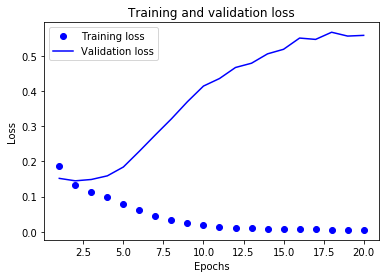

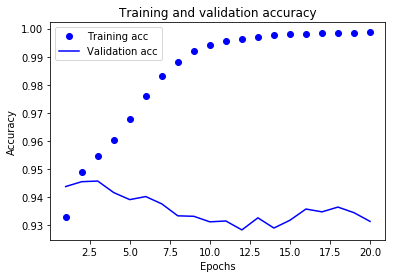

In [25]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [26]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=2)
print('Accuracy validate: %f' % (accuracy*100))

Accuracy validate: 93.141472


In [29]:
import pandas
vect_range=list(range(30))
range_epoch = pandas.DataFrame(vect_range)
val_acc2 = pandas.DataFrame(val_acc)
best_acc = pandas.concat([range_epoch, val_acc2], axis=1)
best_acc.columns = ['a','b']
epoch=best_acc.loc[best_acc['b']==max(best_acc['b']),"a"]

new_epoch=int(epoch+1)
print(int(new_epoch))

3


In [30]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=["accuracy"])

model.fit(x_train, y_train,
                    epochs=new_epoch,
                    batch_size=1024,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          9000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 9,480,065
Trainable params: 9,480,065
Non-trainable params: 0
_________________________________________________________________
Train on 1088338 samples, validate on 536048 samples
Epoch 1/3


 437248/1088338 [===========>..................] - ETA: 11:07 - loss: 0.7111 - acc: 0.46 - ETA: 4:03 - loss: 0.5996 - acc: 0.7643 - ETA: 2:38 - loss: 0.5564 - acc: 0.829 - ETA: 2:01 - loss: 0.5412 - acc: 0.855 - ETA: 1:41 - loss: 0.5147 - acc: 0.869 - ETA: 1:28 - loss: 0.4827 - acc: 0.878 - ETA: 1:19 - loss: 0.4615 - acc: 0.884 - ETA: 1:13 - loss: 0.4393 - acc: 0.890 - ETA: 1:08 - loss: 0.4227 - acc: 0.893 - ETA: 1:04 - loss: 0.4095 - acc: 0.895 - ETA: 1:00 - loss: 0.3975 - acc: 0.898 - ETA: 58s - loss: 0.3883 - acc: 0.900 - ETA: 55s - loss: 0.3798 - acc: 0.90 - ETA: 54s - loss: 0.3706 - acc: 0.90 - ETA: 52s - loss: 0.3655 - acc: 0.90 - ETA: 50s - loss: 0.3588 - acc: 0.90 - ETA: 49s - loss: 0.3551 - acc: 0.90 - ETA: 48s - loss: 0.3506 - acc: 0.90 - ETA: 47s - loss: 0.3449 - acc: 0.90 - ETA: 46s - loss: 0.3413 - acc: 0.90 - ETA: 45s - loss: 0.3368 - acc: 0.90 - ETA: 44s - loss: 0.3321 - acc: 0.90 - ETA: 44s - loss: 0.3282 - acc: 0.90 - ETA: 43s - loss: 0.3252 - acc: 0.91 - ETA: 42s - lo

 877568/1088338 [=======================>......] - ETA: 20s - loss: 0.2204 - acc: 0.92 - ETA: 20s - loss: 0.2202 - acc: 0.92 - ETA: 19s - loss: 0.2200 - acc: 0.92 - ETA: 19s - loss: 0.2198 - acc: 0.92 - ETA: 19s - loss: 0.2196 - acc: 0.92 - ETA: 19s - loss: 0.2194 - acc: 0.92 - ETA: 19s - loss: 0.2192 - acc: 0.92 - ETA: 19s - loss: 0.2191 - acc: 0.92 - ETA: 19s - loss: 0.2188 - acc: 0.92 - ETA: 19s - loss: 0.2187 - acc: 0.92 - ETA: 19s - loss: 0.2185 - acc: 0.92 - ETA: 19s - loss: 0.2183 - acc: 0.92 - ETA: 19s - loss: 0.2182 - acc: 0.92 - ETA: 19s - loss: 0.2180 - acc: 0.92 - ETA: 19s - loss: 0.2179 - acc: 0.92 - ETA: 19s - loss: 0.2176 - acc: 0.92 - ETA: 19s - loss: 0.2175 - acc: 0.92 - ETA: 18s - loss: 0.2174 - acc: 0.92 - ETA: 18s - loss: 0.2172 - acc: 0.92 - ETA: 18s - loss: 0.2171 - acc: 0.92 - ETA: 18s - loss: 0.2169 - acc: 0.92 - ETA: 18s - loss: 0.2167 - acc: 0.92 - ETA: 18s - loss: 0.2166 - acc: 0.92 - ETA: 18s - loss: 0.2164 - acc: 0.92 - ETA: 18s - loss: 0.2163 - acc: 0.92 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.1938 - acc: 0.931 - ETA: 6s - loss: 0.1937 - acc: 0.931 - ETA: 6s - loss: 0.1935 - acc: 0.931 - ETA: 6s - loss: 0.1934 - acc: 0.931 - ETA: 6s - loss: 0.1933 - acc: 0.931 - ETA: 6s - loss: 0.1933 - acc: 0.931 - ETA: 5s - loss: 0.1931 - acc: 0.931 - ETA: 5s - loss: 0.1930 - acc: 0.931 - ETA: 5s - loss: 0.1929 - acc: 0.931 - ETA: 5s - loss: 0.1929 - acc: 0.931 - ETA: 5s - loss: 0.1928 - acc: 0.931 - ETA: 5s - loss: 0.1926 - acc: 0.931 - ETA: 5s - loss: 0.1926 - acc: 0.931 - ETA: 5s - loss: 0.1925 - acc: 0.931 - ETA: 5s - loss: 0.1924 - acc: 0.931 - ETA: 5s - loss: 0.1923 - acc: 0.931 - ETA: 5s - loss: 0.1922 - acc: 0.931 - ETA: 5s - loss: 0.1922 - acc: 0.931 - ETA: 5s - loss: 0.1921 - acc: 0.931 - ETA: 5s - loss: 0.1920 - acc: 0.931 - ETA: 5s - loss: 0.1919 - acc: 0.931 - ETA: 5s - loss: 0.1919 - acc: 0.931 - ETA: 4s - loss: 0.1918 - acc: 0.931 - ETA: 4s - loss: 0.1916 - acc: 0.931 - ETA: 4s - loss: 0.1915 - acc: 0.931 -

 438272/1088338 [===========>..................] - ETA: 58s - loss: 0.1444 - acc: 0.95 - ETA: 40s - loss: 0.1516 - acc: 0.94 - ETA: 36s - loss: 0.1447 - acc: 0.94 - ETA: 35s - loss: 0.1373 - acc: 0.94 - ETA: 34s - loss: 0.1318 - acc: 0.94 - ETA: 33s - loss: 0.1354 - acc: 0.94 - ETA: 33s - loss: 0.1346 - acc: 0.94 - ETA: 33s - loss: 0.1344 - acc: 0.94 - ETA: 32s - loss: 0.1320 - acc: 0.94 - ETA: 32s - loss: 0.1320 - acc: 0.94 - ETA: 32s - loss: 0.1331 - acc: 0.94 - ETA: 32s - loss: 0.1321 - acc: 0.94 - ETA: 32s - loss: 0.1326 - acc: 0.94 - ETA: 32s - loss: 0.1319 - acc: 0.94 - ETA: 31s - loss: 0.1319 - acc: 0.94 - ETA: 31s - loss: 0.1322 - acc: 0.94 - ETA: 31s - loss: 0.1329 - acc: 0.94 - ETA: 31s - loss: 0.1329 - acc: 0.94 - ETA: 31s - loss: 0.1333 - acc: 0.94 - ETA: 31s - loss: 0.1333 - acc: 0.94 - ETA: 31s - loss: 0.1334 - acc: 0.94 - ETA: 31s - loss: 0.1328 - acc: 0.94 - ETA: 31s - loss: 0.1330 - acc: 0.94 - ETA: 31s - loss: 0.1326 - acc: 0.94 - ETA: 30s - loss: 0.1330 - acc: 0.94 -

 878592/1088338 [=======================>......] - ETA: 19s - loss: 0.1326 - acc: 0.94 - ETA: 19s - loss: 0.1325 - acc: 0.94 - ETA: 19s - loss: 0.1325 - acc: 0.94 - ETA: 19s - loss: 0.1324 - acc: 0.94 - ETA: 19s - loss: 0.1324 - acc: 0.94 - ETA: 19s - loss: 0.1325 - acc: 0.94 - ETA: 19s - loss: 0.1325 - acc: 0.94 - ETA: 19s - loss: 0.1324 - acc: 0.94 - ETA: 19s - loss: 0.1325 - acc: 0.94 - ETA: 19s - loss: 0.1324 - acc: 0.94 - ETA: 19s - loss: 0.1323 - acc: 0.94 - ETA: 19s - loss: 0.1323 - acc: 0.94 - ETA: 19s - loss: 0.1323 - acc: 0.94 - ETA: 18s - loss: 0.1323 - acc: 0.94 - ETA: 18s - loss: 0.1323 - acc: 0.94 - ETA: 18s - loss: 0.1323 - acc: 0.94 - ETA: 18s - loss: 0.1324 - acc: 0.94 - ETA: 18s - loss: 0.1323 - acc: 0.94 - ETA: 18s - loss: 0.1324 - acc: 0.94 - ETA: 18s - loss: 0.1325 - acc: 0.94 - ETA: 18s - loss: 0.1325 - acc: 0.94 - ETA: 18s - loss: 0.1325 - acc: 0.94 - ETA: 18s - loss: 0.1325 - acc: 0.94 - ETA: 18s - loss: 0.1325 - acc: 0.94 - ETA: 18s - loss: 0.1326 - acc: 0.94 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.1322 - acc: 0.949 - ETA: 6s - loss: 0.1322 - acc: 0.949 - ETA: 6s - loss: 0.1322 - acc: 0.949 - ETA: 6s - loss: 0.1322 - acc: 0.949 - ETA: 6s - loss: 0.1322 - acc: 0.949 - ETA: 6s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 5s - loss: 0.1321 - acc: 0.949 - ETA: 5s - loss: 0.1322 - acc: 0.949 - ETA: 4s - loss: 0.1322 - acc: 0.949 - ETA: 4s - loss: 0.1322 - acc: 0.949 - ETA: 4s - loss: 0.1322 - acc: 0.949 -

 439296/1088338 [===========>..................] - ETA: 1:06 - loss: 0.1244 - acc: 0.947 - ETA: 44s - loss: 0.1271 - acc: 0.948 - ETA: 39s - loss: 0.1196 - acc: 0.95 - ETA: 37s - loss: 0.1149 - acc: 0.95 - ETA: 36s - loss: 0.1132 - acc: 0.95 - ETA: 36s - loss: 0.1142 - acc: 0.95 - ETA: 35s - loss: 0.1145 - acc: 0.95 - ETA: 35s - loss: 0.1140 - acc: 0.95 - ETA: 34s - loss: 0.1132 - acc: 0.95 - ETA: 34s - loss: 0.1121 - acc: 0.95 - ETA: 34s - loss: 0.1124 - acc: 0.95 - ETA: 34s - loss: 0.1113 - acc: 0.95 - ETA: 34s - loss: 0.1115 - acc: 0.95 - ETA: 33s - loss: 0.1106 - acc: 0.95 - ETA: 33s - loss: 0.1116 - acc: 0.95 - ETA: 33s - loss: 0.1113 - acc: 0.95 - ETA: 33s - loss: 0.1110 - acc: 0.95 - ETA: 33s - loss: 0.1110 - acc: 0.95 - ETA: 33s - loss: 0.1102 - acc: 0.95 - ETA: 33s - loss: 0.1099 - acc: 0.95 - ETA: 33s - loss: 0.1093 - acc: 0.95 - ETA: 33s - loss: 0.1095 - acc: 0.95 - ETA: 32s - loss: 0.1089 - acc: 0.95 - ETA: 32s - loss: 0.1083 - acc: 0.95 - ETA: 32s - loss: 0.1089 - acc: 0.9

 876544/1088338 [=======================>......] - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1117 - acc: 0.95 - ETA: 19s - loss: 0.1117 - acc: 0.95 - ETA: 19s - loss: 0.1116 - acc: 0.95 - ETA: 19s - loss: 0.1117 - acc: 0.95 - ETA: 19s - loss: 0.1117 - acc: 0.95 - ETA: 19s - loss: 0.1118 - acc: 0.95 - ETA: 19s - loss: 0.1118 - acc: 0.95 - ETA: 19s - loss: 0.1118 - acc: 0.95 - ETA: 19s - loss: 0.1118 - acc: 0.95 - ETA: 19s - loss: 0.1119 - acc: 0.95 - ETA: 18s - loss: 0.1118 - acc: 0.95 - ETA: 18s - loss: 0.1118 - acc: 0.95 - ETA: 18s - loss: 0.1118 - acc: 0.95 - ETA: 18s - loss: 0.1119 - acc: 0.95 - ETA: 18s - loss: 0.1120 - acc: 0.95 - ETA: 18s - loss: 0.1120 - acc: 0.95 - ETA: 18s - loss: 0.1120 - acc: 0.95 - ETA: 18s - loss: 0.1120 - acc: 0.95 - ETA: 18s - loss: 0.1121 - acc: 0.95 -

1088338/1088338 [==============================] - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 6s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1137 - acc: 0.954 - ETA: 5s - loss: 0.1137 - acc: 0.954 - ETA: 5s - loss: 0.1137 - acc: 0.954 - ETA: 5s - loss: 0.1136 - acc: 0.954 - ETA: 5s - loss: 0.1137 - acc: 0.954 - ETA: 5s - loss: 0.1137 - acc: 0.954 - ETA: 5s - loss: 0.1137 - acc: 0.954 -

In [31]:
# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=2)
print('Accuracy train: %f' % (accuracy*100))

# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=2)
print('Accuracy validate: %f' % (accuracy*100))

Accuracy train: 96.211012
Accuracy validate: 94.401994


In [32]:
# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print('Accuracy validate: %f' % (accuracy*100))

Accuracy validate: 94.382452
